In [1]:
from pathlib import Path
import pandas as pd
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
import numpy as np
import itertools
import random

from keras.preprocessing.sequence import pad_sequences

from transformers import BertTokenizer
from transformers import BertModel, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from transformers import DistilBertModel, AdamW
from transformers import BertForSequenceClassification

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from pandarallel import pandarallel
pandarallel.initialize()

import os
os.chdir('..')

from src.data_lexical import LexDataset, read_lexical_corpus
from src.data_disambiguation import DisDataset, read_disambiguation_corpus
from src.model import BertForSharedTaskBaseline
from src.training import train, evaluate, forward_func_custom_bert

Using TensorFlow backend.


INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
import math
import os
import warnings
from dataclasses import dataclass
from typing import Optional, Tuple

import torch
import torch.utils.checkpoint
from torch import nn
from torch.nn import CrossEntropyLoss, MSELoss
from transformers import BertPreTrainedModel, BertModel
from transformers.modeling_outputs import SequenceClassifierOutput


class BertForSharedTaskMultitask(BertPreTrainedModel):

    _keys_to_ignore_on_load_unexpected = [r"pooler"]

    def __init__(self, config):
        super().__init__(config)
        self.num_labels_first_task = 1 # Regression
        self.num_labels_second_task = config.num_labels # Word sense disambiguation

        self.bert = BertModel(config)
        self.dropout_first = nn.Dropout(config.hidden_dropout_prob)
        self.dropout_second = nn.Dropout(config.hidden_dropout_prob)
        
        self.classifier_first = nn.Linear(config.hidden_size, self.num_labels_first_task)
        self.classifier_second = nn.Linear(config.hidden_size, self.num_labels_second_task)

        self.init_weights()
        

    def forward(
        self,
        input_ids=None,
        target_positions=None,
        task_id=1,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`):
            Labels for computing the token classification loss. Indices should be in ``[0, ..., config.num_labels -
            1]``.
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        if task_id == 1:
            pooled_output = outputs[0][torch.arange(outputs[0].size(0)), target_positions]
            pooled_output = self.dropout_first(pooled_output)
            logits = self.classifier_first(pooled_output)

            loss = None
            if labels is not None:
                if self.num_labels_first_task == 1:
                    #  We are doing regression
                    loss_fct = MSELoss()
                    loss = loss_fct(logits.view(-1), labels.view(-1))
                else:
                    loss_fct = CrossEntropyLoss()
                    loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

            if not return_dict:
                output = (logits,) + outputs[2:]
                return ((loss,) + output) if loss is not None else output

            return SequenceClassifierOutput(
                loss=loss,
                logits=logits,
                hidden_states=outputs.hidden_states,
                attentions=outputs.attentions,
            )
        elif task_id == 2:
            sequence_output = outputs[0]

            sequence_output = self.dropout_second(sequence_output)
            logits = self.classifier_second(sequence_output)

            loss = None
            if labels is not None:
                loss_fct = CrossEntropyLoss()
                # Only keep active parts of the loss
                if attention_mask is not None:
                    active_loss = attention_mask.view(-1) == 1
                    active_logits = logits.view(-1, self.num_labels_second_task)
                    active_labels = torch.where(
                        active_loss, labels.view(-1), torch.tensor(loss_fct.ignore_index).type_as(labels)
                    )
                    loss = loss_fct(active_logits, active_labels)
                else:
                    loss = loss_fct(logits.view(-1, self.num_labels_second_task), labels.view(-1))

            if not return_dict:
                output = (logits,) + outputs[2:]
                return ((loss,) + output) if loss is not None else output

            return TokenClassifierOutput(
                loss=loss,
                logits=logits,
                hidden_states=outputs.hidden_states,
                attentions=outputs.attentions,
            )


In [3]:
def forward_func_multitask_same_bert(batch, device, model, additional_params):

    # Clear gradients
    model.zero_grad()    
    
    
    b_input_ids = batch['task_1']['input_ids'].to(device)
    b_input_mask = batch['task_1']['attention_mask'].to(device)
    b_labels = batch['task_1']['labels'].to(device)
    b_positions =  batch['task_1']['target_positions'].to(device)
      
    loss_1, logits = model(b_input_ids, 
                             b_positions,
                             task_id=1,
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
    
    b_input_ids = batch['task_2']['input_ids'].to(device)
    b_input_mask = batch['task_2']['attention_mask'].to(device)
    b_labels = batch['task_2']['labels'].to(device)

    loss_2, _ = model(b_input_ids, 
                             task_id=2,
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
    
    return 0.8 * loss_1 + 0.2 * loss_2, logits

In [4]:
def forward_func_multitask_bert(batch, device, model, additional_params):

    # Clear gradients
    model.zero_grad()      
    b_input_ids = batch['input_ids'].to(device)
    b_input_mask = batch['attention_mask'].to(device)
        
    if additional_params['task_id'] == 1:
        b_labels = batch['labels'].to(device)
        b_positions =  batch['target_positions'].to(device)
      
        loss, logits = model(b_input_ids, 
                             b_positions,
                             task_id=1,
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
    elif additional_params['task_id'] == 2:
        b_labels = batch['labels'].to(device)

        loss, logits = model(b_input_ids, 
                             task_id=2,
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
    return loss, logits

In [5]:
epochs = 43
seed_val = 42
results_window = {}
max_len = 22
stop_at = 7

In [6]:
data_sent_dis, data_senses_dis = read_disambiguation_corpus(max_len=max_len)

In [7]:
len(data_sent_dis)

7932

In [8]:
tag_values = list(set(list(itertools.chain(*data_senses_dis))))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

In [9]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [10]:
from xml.dom import minidom
from bs4 import BeautifulSoup
from pathlib import Path
import pandas as pd
import numpy as np
import torch

class MultiDataset(torch.utils.data.Dataset):
    def __init__(self, encodings_dis, labels_dis, encodings_lex, labels_lex, positions_lex):
        self.encodings_dis = encodings_dis
        self.labels_dis = labels_dis
        
        self.encodings_lex = encodings_lex
        self.labels_lex = labels_lex
        self.positions_lex = positions_lex

    def __getitem__(self, idx):
        item = {}
        
        task_1 = {key: torch.tensor(val[idx]) for key, val in self.encodings_lex.items()}
        task_1['labels'] = torch.tensor(self.labels_lex[idx])
        task_1['target_positions'] = torch.tensor(self.positions_lex[idx])
        
        task_2 = {key: torch.tensor(val[idx]) for key, val in self.encodings_dis.items()}
        task_2['labels'] = torch.tensor(self.labels_dis[idx])
        
        item['task_2'] = task_2
        item['task_1'] = task_1
        return item

    def __len__(self):
        return len(self.labels_dis)

In [ ]:
import random
import numpy as np
from transformers import get_linear_schedule_with_warmup

for window_x in [0, 1, 2]:
    print('Window size of ', window_x)
    data_texts, data_corpus, data_labels, sentence_raw, target_words, positions = read_lexical_corpus('data/raw/lcp_single_train.tsv',
                                                                           return_complete_sent=False,
                                                                           window_size=window_x + 1)
    torch.cuda.manual_seed_all(seed_val)

    kf = StratifiedKFold(8, shuffle=True, random_state=0)

    history_preds = []
    history_samples = []
    history_input = []
    history_target = []
    history_index = []
    history_labels = []
    history_occur_text = []
    history_occur_target = []
    ix_fold = 0

    for train_index, val_index in kf.split(data_texts, data_corpus):
        print('Starting a new fold ...')

        train_texts_lex, train_labels_lex, train_positions_lex, train_target_words_lex = data_texts[train_index], data_labels[train_index], positions[train_index], target_words[train_index]
        val_texts_lex, val_labels_lex, val_positions_lex, val_target_words_lex = data_texts[val_index], data_labels[val_index], positions[val_index], target_words[val_index]

        train_encodings_lex = tokenizer(list(train_texts_lex), truncation=True, padding=True)

        val_encodings_lex = tokenizer(list(val_texts_lex), truncation=True, padding=True)
        val_dataset_lex = LexDataset(val_encodings_lex, val_labels_lex, val_positions_lex)
        val_loader_lex = DataLoader(val_dataset_lex, batch_size=1)
        
        all_text = ' '.join(train_texts_lex)
        occurence_text = [all_text.count(w) for w in val_target_words_lex]
        
        occurence_target = [train_target_words_lex.tolist().count(w) for w in val_target_words_lex]
        
        device = torch.device("cuda:0")
        
        model = BertForSharedTaskMultitask.from_pretrained(
            "bert-base-uncased", 
            num_labels = len(tag2idx), 
            output_attentions = False, 
            output_hidden_states = False, 
        )
        model.cuda(0)

        optimizer = AdamW(model.parameters(),
                          lr = 2e-5, 
                          eps = 1e-8
                        )

        random.seed(seed_val)
        torch.manual_seed(seed_val)

        tracking_metrics = []
        tracking_logits = []
        early_stopping = 0
        best_metric = 1000000
        
        for epoch_i in range(0, epochs):
            np.random.seed(epoch_i)
            sample_data_sent = np.random.choice(data_sent_dis, len(train_texts_lex), replace=False)
            
            np.random.seed(epoch_i)
            sample_data_sense = np.random.choice(data_senses_dis, len(train_texts_lex), replace=False)
            
            train_encodings_dis = tokenizer(list(sample_data_sent), truncation=True, padding=True, max_length=max_len)
            data_tags_dis = pad_sequences([[tag2idx.get(l) for l in lab] for lab in sample_data_sense],
                     maxlen=max_len, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")
            
            train_dataset_multi = MultiDataset(train_encodings_dis, data_tags_dis, train_encodings_lex, train_labels_lex, train_positions_lex)
            train_loader_multi = DataLoader(train_dataset_multi, batch_size=16)
            
            total_steps = len(train_loader_multi) * epochs
            scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                    num_warmup_steps = 0, # Default value in run_glue.py
                                                    num_training_steps = total_steps)           
            print()
            print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
            train(device, model, train_loader_multi, forward_func_multitask_same_bert, optimizer, scheduler, {})
            
            training_stats, all_logits, val_metric = evaluate(device, model, val_loader_lex, forward_func_multitask_bert, {'task_id': 1})

            tracking_metrics.append(val_metric)
            tracking_logits.append(all_logits)
            
            if val_metric > best_metric:
                early_stopping += 1
            else:
                best_metric = val_metric
                
            if early_stopping == stop_at:
                break
            
        index_min = np.argmin(tracking_metrics)
            
        history_labels.extend(val_labels_lex)
        history_preds.extend(tracking_logits[index_min])
        history_samples.extend(val_texts_lex)
        history_input.extend(sentence_raw[val_index])
        history_target.extend(target_words[val_index])
        history_index.extend(([ix_fold] * len(val_index)))
        history_occur_text.extend(occurence_text)
        history_occur_target.extend(occurence_target)
        ix_fold += 1

        print("")
        print("Training complete!")
        
        del model
        torch.cuda.empty_cache()
        
    results = pd.DataFrame()
    results['samples'] = history_samples
    results['preds'] = history_preds
    results['true_val'] = history_labels
    results['raw'] = history_input
    results['raw'] = results['raw'].astype(str)
    results['target'] = history_target
    results['index'] = history_index
    results['occur_text'] = history_occur_text
    results['occur_target'] = history_occur_target
    
    results_window[window_x] = results

Window size of  0
Starting a new fold ...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSharedTaskMultitask: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSharedTaskMultitask from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSharedTaskMultitask from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSharedTaskMultitask were not initialized from the model checkpoint at bert-base-u


======== Epoch 1 / 43 ========
Training...

  Average training loss: 0.353784

Running Validation...
  Metric: 0.270030
  Validation Loss: 0.086451


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 2 / 43 ========
Training...

  Average training loss: 0.221082

Running Validation...
  Metric: 0.283222
  Validation Loss: 0.093466


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 3 / 43 ========
Training...

  Average training loss: 0.206544

Running Validation...
  Metric: 0.266429
  Validation Loss: 0.083501


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 4 / 43 ========
Training...

  Average training loss: 0.193271

Running Validation...
  Metric: 0.258765
  Validation Loss: 0.078449


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 5 / 43 ========
Training...

  Average training loss: 0.180161

Running Validation...
  Metric: 0.240882
  Validation Loss: 0.068244


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 6 / 43 ========
Training...

  Average training loss: 0.171308

Running Validation...
  Metric: 0.214580
  Validation Loss: 0.055024


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 7 / 43 ========
Training...

  Average training loss: 0.163119

Running Validation...
  Metric: 0.202749
  Validation Loss: 0.048967


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 8 / 43 ========
Training...

  Average training loss: 0.155956

Running Validation...
  Metric: 0.196293
  Validation Loss: 0.046380


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 9 / 43 ========
Training...

  Average training loss: 0.149379

Running Validation...
  Metric: 0.184493
  Validation Loss: 0.041444


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 10 / 43 ========
Training...

  Average training loss: 0.141830

Running Validation...
  Metric: 0.178330
  Validation Loss: 0.038835


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 11 / 43 ========
Training...

  Average training loss: 0.136087

Running Validation...
  Metric: 0.174773
  Validation Loss: 0.037368


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 12 / 43 ========
Training...

  Average training loss: 0.128905

Running Validation...
  Metric: 0.162481
  Validation Loss: 0.033052


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 13 / 43 ========
Training...

  Average training loss: 0.122102

Running Validation...
  Metric: 0.155432
  Validation Loss: 0.030445


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 14 / 43 ========
Training...

  Average training loss: 0.115519

Running Validation...
  Metric: 0.147919
  Validation Loss: 0.027949


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 15 / 43 ========
Training...

  Average training loss: 0.108233

Running Validation...
  Metric: 0.141089
  Validation Loss: 0.025775


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 16 / 43 ========
Training...

  Average training loss: 0.102385

Running Validation...
  Metric: 0.152635
  Validation Loss: 0.029443


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 17 / 43 ========
Training...

  Average training loss: 0.096358

Running Validation...
  Metric: 0.142102
  Validation Loss: 0.026218


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 18 / 43 ========
Training...

  Average training loss: 0.091208

Running Validation...
  Metric: 0.140670
  Validation Loss: 0.025614


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 19 / 43 ========
Training...

  Average training loss: 0.086201

Running Validation...
  Metric: 0.134884
  Validation Loss: 0.023789


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 20 / 43 ========
Training...

  Average training loss: 0.080537

Running Validation...
  Metric: 0.125391
  Validation Loss: 0.021129


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 21 / 43 ========
Training...

  Average training loss: 0.075741

Running Validation...
  Metric: 0.125381
  Validation Loss: 0.021162


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 22 / 43 ========
Training...

  Average training loss: 0.070824

Running Validation...
  Metric: 0.128512
  Validation Loss: 0.022170


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 23 / 43 ========
Training...

  Average training loss: 0.068209

Running Validation...
  Metric: 0.132360
  Validation Loss: 0.023323


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 24 / 43 ========
Training...

  Average training loss: 0.063964

Running Validation...
  Metric: 0.116925
  Validation Loss: 0.018750


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 25 / 43 ========
Training...

  Average training loss: 0.060681

Running Validation...
  Metric: 0.109539
  Validation Loss: 0.016859


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 26 / 43 ========
Training...

  Average training loss: 0.056684

Running Validation...
  Metric: 0.107674
  Validation Loss: 0.016396


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 27 / 43 ========
Training...

  Average training loss: 0.053379

Running Validation...
  Metric: 0.110303
  Validation Loss: 0.016984


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 28 / 43 ========
Training...

  Average training loss: 0.050781

Running Validation...
  Metric: 0.107932
  Validation Loss: 0.016399

Training complete!
Starting a new fold ...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSharedTaskMultitask: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSharedTaskMultitask from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSharedTaskMultitask from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSharedTaskMultitask were not initialized from the model checkpoint at bert-base-u


======== Epoch 1 / 43 ========
Training...

  Average training loss: 0.352590

Running Validation...
  Metric: 0.274812
  Validation Loss: 0.088317


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 2 / 43 ========
Training...

  Average training loss: 0.221215

Running Validation...
  Metric: 0.286018
  Validation Loss: 0.094249


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 3 / 43 ========
Training...

  Average training loss: 0.206186

Running Validation...
  Metric: 0.265499
  Validation Loss: 0.082092


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 4 / 43 ========
Training...

  Average training loss: 0.192815

Running Validation...
  Metric: 0.248711
  Validation Loss: 0.072655


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 5 / 43 ========
Training...

  Average training loss: 0.180520

Running Validation...
  Metric: 0.220295
  Validation Loss: 0.057906


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 6 / 43 ========
Training...

  Average training loss: 0.171177

Running Validation...
  Metric: 0.220297
  Validation Loss: 0.057544


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 7 / 43 ========
Training...

  Average training loss: 0.163313

Running Validation...
  Metric: 0.212348
  Validation Loss: 0.053517


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 8 / 43 ========
Training...

  Average training loss: 0.156117

Running Validation...
  Metric: 0.189571
  Validation Loss: 0.043561


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 9 / 43 ========
Training...

  Average training loss: 0.148911

Running Validation...
  Metric: 0.171640
  Validation Loss: 0.036591


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 10 / 43 ========
Training...

  Average training loss: 0.141605

Running Validation...
  Metric: 0.171315
  Validation Loss: 0.036335


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 11 / 43 ========
Training...

  Average training loss: 0.135412

Running Validation...
  Metric: 0.162764
  Validation Loss: 0.033327


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 12 / 43 ========
Training...

  Average training loss: 0.127207

Running Validation...
  Metric: 0.159799
  Validation Loss: 0.032422


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 13 / 43 ========
Training...

  Average training loss: 0.120262

Running Validation...
  Metric: 0.153090
  Validation Loss: 0.030104


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 14 / 43 ========
Training...

  Average training loss: 0.113273

Running Validation...
  Metric: 0.153991
  Validation Loss: 0.030605


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 15 / 43 ========
Training...

  Average training loss: 0.106326

Running Validation...
  Metric: 0.149440
  Validation Loss: 0.028934


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 16 / 43 ========
Training...

  Average training loss: 0.099236

Running Validation...
  Metric: 0.143805
  Validation Loss: 0.027208


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 17 / 43 ========
Training...

  Average training loss: 0.093353

Running Validation...
  Metric: 0.144156
  Validation Loss: 0.027439


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 18 / 43 ========
Training...

  Average training loss: 0.087732

Running Validation...
  Metric: 0.139262
  Validation Loss: 0.025739


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 19 / 43 ========
Training...

  Average training loss: 0.082932

Running Validation...
  Metric: 0.138967
  Validation Loss: 0.025727


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 20 / 43 ========
Training...

  Average training loss: 0.077882

Running Validation...
  Metric: 0.126088
  Validation Loss: 0.021831


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 21 / 43 ========
Training...

  Average training loss: 0.073092

Running Validation...
  Metric: 0.124168
  Validation Loss: 0.021099


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 22 / 43 ========
Training...

  Average training loss: 0.068123

Running Validation...
  Metric: 0.117492
  Validation Loss: 0.019196


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 23 / 43 ========
Training...

  Average training loss: 0.065729

Running Validation...
  Metric: 0.105926
  Validation Loss: 0.016233


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 24 / 43 ========
Training...

  Average training loss: 0.061539

Running Validation...
  Metric: 0.102010
  Validation Loss: 0.015332


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 25 / 43 ========
Training...

  Average training loss: 0.058372

Running Validation...
  Metric: 0.103333
  Validation Loss: 0.015627


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 26 / 43 ========
Training...

  Average training loss: 0.054635

Running Validation...
  Metric: 0.097041
  Validation Loss: 0.014143


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 27 / 43 ========
Training...

  Average training loss: 0.051056

Running Validation...
  Metric: 0.094443
  Validation Loss: 0.013397


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 28 / 43 ========
Training...

  Average training loss: 0.048574

Running Validation...
  Metric: 0.093306
  Validation Loss: 0.013064


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 29 / 43 ========
Training...

  Average training loss: 0.045749

Running Validation...
  Metric: 0.089843
  Validation Loss: 0.012071


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 30 / 43 ========
Training...

  Average training loss: 0.042546

Running Validation...
  Metric: 0.085243
  Validation Loss: 0.011115


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 31 / 43 ========
Training...

  Average training loss: 0.040659

Running Validation...
  Metric: 0.084399
  Validation Loss: 0.010815


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 32 / 43 ========
Training...

  Average training loss: 0.038603

Running Validation...
  Metric: 0.081375
  Validation Loss: 0.010145


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 33 / 43 ========
Training...

  Average training loss: 0.035757

Running Validation...
  Metric: 0.078984
  Validation Loss: 0.009647


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 34 / 43 ========
Training...

  Average training loss: 0.034062

Running Validation...
  Metric: 0.078438
  Validation Loss: 0.009537


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 35 / 43 ========
Training...

  Average training loss: 0.031956

Running Validation...
  Metric: 0.079681
  Validation Loss: 0.009845


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 36 / 43 ========
Training...

  Average training loss: 0.029589

Running Validation...
  Metric: 0.077576
  Validation Loss: 0.009228


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 37 / 43 ========
Training...

  Average training loss: 0.028555

Running Validation...
  Metric: 0.079603
  Validation Loss: 0.009680

Training complete!
Starting a new fold ...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSharedTaskMultitask: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSharedTaskMultitask from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSharedTaskMultitask from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSharedTaskMultitask were not initialized from the model checkpoint at bert-base-u


======== Epoch 1 / 43 ========
Training...

  Average training loss: 0.351171

Running Validation...
  Metric: 0.324515
  Validation Loss: 0.119733


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 2 / 43 ========
Training...

  Average training loss: 0.220581

Running Validation...
  Metric: 0.254385
  Validation Loss: 0.076869


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 3 / 43 ========
Training...

  Average training loss: 0.202252

Running Validation...
  Metric: 0.240062
  Validation Loss: 0.068768


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 4 / 43 ========
Training...

  Average training loss: 0.189337

Running Validation...
  Metric: 0.221078
  Validation Loss: 0.059118


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 5 / 43 ========
Training...

  Average training loss: 0.177012

Running Validation...
  Metric: 0.206645
  Validation Loss: 0.051899


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 6 / 43 ========
Training...

  Average training loss: 0.167857

Running Validation...
  Metric: 0.201078
  Validation Loss: 0.048871


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 7 / 43 ========
Training...

  Average training loss: 0.159983

Running Validation...
  Metric: 0.185851
  Validation Loss: 0.042326


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 8 / 43 ========
Training...

  Average training loss: 0.152375

Running Validation...
  Metric: 0.183329
  Validation Loss: 0.041275


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 9 / 43 ========
Training...

  Average training loss: 0.145154

Running Validation...
  Metric: 0.173852
  Validation Loss: 0.037678


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 10 / 43 ========
Training...

  Average training loss: 0.137992

Running Validation...
  Metric: 0.167327
  Validation Loss: 0.035238


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 11 / 43 ========
Training...

  Average training loss: 0.130810

Running Validation...
  Metric: 0.158842
  Validation Loss: 0.032285


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 12 / 43 ========
Training...

  Average training loss: 0.122731

Running Validation...
  Metric: 0.150514
  Validation Loss: 0.029487


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 13 / 43 ========
Training...

  Average training loss: 0.115971

Running Validation...
  Metric: 0.149778
  Validation Loss: 0.029201


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 14 / 43 ========
Training...

  Average training loss: 0.108653

Running Validation...
  Metric: 0.136863
  Validation Loss: 0.025292


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 15 / 43 ========
Training...

  Average training loss: 0.101667

Running Validation...
  Metric: 0.134161
  Validation Loss: 0.024665


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 16 / 43 ========
Training...

  Average training loss: 0.095509

Running Validation...
  Metric: 0.128297
  Validation Loss: 0.022494


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 17 / 43 ========
Training...

  Average training loss: 0.089861

Running Validation...
  Metric: 0.124170
  Validation Loss: 0.021583


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 18 / 43 ========
Training...

  Average training loss: 0.085031

Running Validation...
  Metric: 0.120350
  Validation Loss: 0.020222


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 19 / 43 ========
Training...

  Average training loss: 0.080175

Running Validation...
  Metric: 0.115025
  Validation Loss: 0.018808


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 20 / 43 ========
Training...

  Average training loss: 0.075075

Running Validation...
  Metric: 0.112623
  Validation Loss: 0.018212


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 21 / 43 ========
Training...

  Average training loss: 0.070564

Running Validation...
  Metric: 0.112989
  Validation Loss: 0.018221


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 22 / 43 ========
Training...

  Average training loss: 0.065546

Running Validation...
  Metric: 0.105787
  Validation Loss: 0.016313


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 23 / 43 ========
Training...

  Average training loss: 0.062979

Running Validation...
  Metric: 0.105108
  Validation Loss: 0.016105


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 24 / 43 ========
Training...

  Average training loss: 0.058859

Running Validation...
  Metric: 0.101800
  Validation Loss: 0.015268


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 25 / 43 ========
Training...

  Average training loss: 0.056101

Running Validation...
  Metric: 0.101114
  Validation Loss: 0.015129


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 26 / 43 ========
Training...

  Average training loss: 0.052470

Running Validation...
  Metric: 0.096609
  Validation Loss: 0.013963


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 27 / 43 ========
Training...

  Average training loss: 0.049273

Running Validation...
  Metric: 0.093336
  Validation Loss: 0.013173


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 28 / 43 ========
Training...

  Average training loss: 0.046871

Running Validation...
  Metric: 0.091148
  Validation Loss: 0.012651


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 29 / 43 ========
Training...

  Average training loss: 0.044212

Running Validation...
  Metric: 0.087953
  Validation Loss: 0.011953


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 30 / 43 ========
Training...

  Average training loss: 0.041612

Running Validation...
  Metric: 0.085203
  Validation Loss: 0.011296


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 31 / 43 ========
Training...

  Average training loss: 0.039655

Running Validation...
  Metric: 0.082819
  Validation Loss: 0.010850


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 32 / 43 ========
Training...

  Average training loss: 0.037305

Running Validation...
  Metric: 0.083203
  Validation Loss: 0.010840


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 33 / 43 ========
Training...

  Average training loss: 0.034879

Running Validation...
  Metric: 0.081600
  Validation Loss: 0.010515


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 34 / 43 ========
Training...

  Average training loss: 0.033278

Running Validation...
  Metric: 0.081233
  Validation Loss: 0.010445


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 35 / 43 ========
Training...

  Average training loss: 0.031169

Running Validation...
  Metric: 0.081876
  Validation Loss: 0.010735


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 36 / 43 ========
Training...

  Average training loss: 0.028550

Running Validation...
  Metric: 0.080598
  Validation Loss: 0.010509


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 37 / 43 ========
Training...

  Average training loss: 0.027562

Running Validation...
  Metric: 0.083200
  Validation Loss: 0.010952


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 38 / 43 ========
Training...

  Average training loss: 0.025692

Running Validation...
  Metric: 0.087404
  Validation Loss: 0.011790


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 39 / 43 ========
Training...

  Average training loss: 0.023758

Running Validation...
  Metric: 0.091482
  Validation Loss: 0.012844


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 40 / 43 ========
Training...

  Average training loss: 0.022409

Running Validation...
  Metric: 0.089035
  Validation Loss: 0.012269

Training complete!
Starting a new fold ...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSharedTaskMultitask: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSharedTaskMultitask from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSharedTaskMultitask from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSharedTaskMultitask were not initialized from the model checkpoint at bert-base-u


======== Epoch 1 / 43 ========
Training...

  Average training loss: 0.363365

Running Validation...
  Metric: 0.272892
  Validation Loss: 0.087208


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 2 / 43 ========
Training...

  Average training loss: 0.217448

Running Validation...
  Metric: 0.270389
  Validation Loss: 0.084968


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 3 / 43 ========
Training...

  Average training loss: 0.202278

Running Validation...
  Metric: 0.257090
  Validation Loss: 0.076974


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 4 / 43 ========
Training...

  Average training loss: 0.188331

Running Validation...
  Metric: 0.241829
  Validation Loss: 0.068367


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 5 / 43 ========
Training...

  Average training loss: 0.176897

Running Validation...
  Metric: 0.210901
  Validation Loss: 0.053123


/home/krivas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



======== Epoch 6 / 43 ========
Training...

  Average training loss: 0.166270

Running Validation...


In [ ]:
for window_ix in results_window:
    results_window[window_ix]['mae'] = results_window[window_ix].apply(lambda x: mean_absolute_error([x.preds],[x.true_val]), axis=1)
    results_window[window_ix]['mse'] = results_window[window_ix].apply(lambda x: mean_squared_error([x.preds],[x.true_val]), axis=1)
    results_window[window_ix]['discrete_occur'] = results_window[window_ix].apply(lambda x: x.occur_target if (x.occur_target == 0 or x.occur_target == 1) else 2, axis=1)
    

In [ ]:
for window_ix in results_window:
    print('Window of', window_ix)

    mae = results_window[window_ix].groupby(['index']).mae.mean()
    mse = results_window[window_ix].groupby(['index']).mse.mean()
    #r_2 = results_window[window_ix].groupby(['index']).
    
    print('MAE --- Mean:', round(np.mean(mae), 4), ' Std:', round(np.std(mae), 4))
    print('MSE --- Mean:', round(np.mean(mse), 4), ' Std:', round(np.std(mse), 4))
    #print('R2  --- Mean:', round(np.mean(r_2), 4), ' Std:', round(np.std(r_2), 4))
    print()


In [18]:
for window_ix in results_window:
    df_temp = results_window[window_ix].groupby(['index', 'discrete_occur']).agg({'mse': 'mean',
                                                                         'mae': 'mean'}).reset_index()
    df_temp = df_temp.groupby('discrete_occur').agg({'mse': ['mean', 'std'],
                                          'mae': ['mean', 'std']}).reset_index()
    df_temp.columns = ['_'.join(col).strip('_') for col in df_temp.columns]
    print('Window of', window_ix)
    print(df_temp)
    print()

Window of 0
   discrete_occur  mse_mean   mse_std  mae_mean   mae_std
0               0  0.010052  0.001028  0.076575  0.003595
1               1  0.009800  0.002017  0.077171  0.008028
2               2  0.007632  0.000492  0.068762  0.002973

Window of 1
   discrete_occur  mse_mean   mse_std  mae_mean   mae_std
0               0  0.010037  0.000888  0.077306  0.002410
1               1  0.009374  0.001208  0.074351  0.003510
2               2  0.008861  0.001095  0.072561  0.003643

Window of 2
   discrete_occur  mse_mean   mse_std  mae_mean   mae_std
0               0  0.011796  0.001363  0.082510  0.003586
1               1  0.010257  0.001518  0.078089  0.005823
2               2  0.009620  0.001000  0.075000  0.003472



In [19]:
import spacy

nlp = spacy.load("en_core_web_sm")
def find_pos(sentence, ref):
    try:
        doc = nlp(sentence)
        for token in doc:
            if token.text == ref:
                return token.pos_
        return np.nan            
    except:
        return np.nan

In [20]:
for window_ix in results_window:
    print(window_ix)
    results_window[window_ix]['pos_label'] =  results_window[window_ix].apply(lambda x: find_pos(x.raw, x.target), axis=1)
    

0
1
2


Window size of: 0


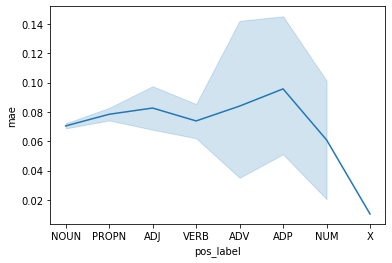

Window size of: 1


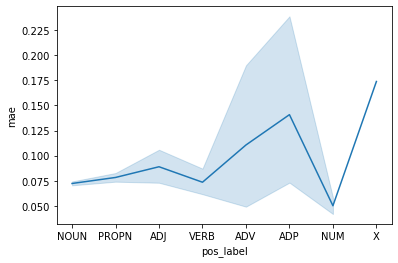

Window size of: 2


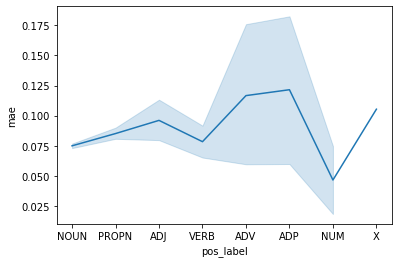

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

for window_ix in results_window:
    print('Window size of:', window_ix)
    sns.lineplot(x='pos_label', y='mae', data=results_window[window_ix].loc[results_window[window_ix].pos_label.notnull()], ci=98, markers='o')
    plt.show()

Window size of: 0


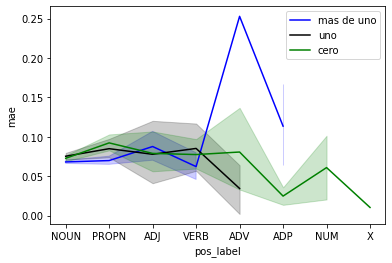

Window size of: 1


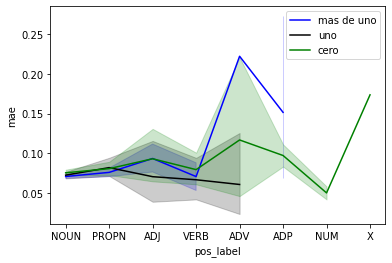

Window size of: 2


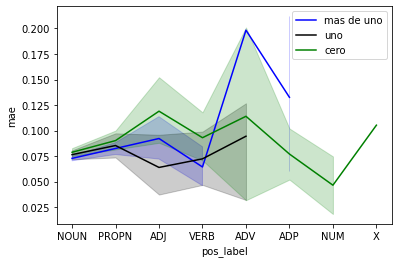

In [22]:
for window_ix in results_window:
    print('Window size of:', window_ix)
    results_many = results_window[window_ix].loc[results_window[window_ix].discrete_occur > 1].reset_index(drop=True)
    results_one = results_window[window_ix].loc[results_window[window_ix].discrete_occur == 1].reset_index(drop=True)
    results_zero = results_window[window_ix].loc[results_window[window_ix].discrete_occur == 0].reset_index(drop=True)
    
    p1 = sns.lineplot(x='pos_label', y='mae', data=results_many.loc[results_many.pos_label.notnull()], ci=98, markers='o', color='blue')
    p2 = sns.lineplot(x='pos_label', y='mae', data=results_one.loc[results_one.pos_label.notnull()], ci=98, markers='o', color='black')
    p3 = sns.lineplot(x='pos_label', y='mae', data=results_zero.loc[results_zero.pos_label.notnull()], ci=98, markers='o', color='green')
    plt.legend(['mas de uno', 'uno', 'cero'])
    plt.show()